<a href="https://colab.research.google.com/github/paulbruffett/python_class/blob/master/M07_Deep_Learning_with_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST Digits Recognition
MNIST is a canonical dataset for machine learning consisting of handwritten digits from 0 - 9 that are 28x28 pixel greyscale images.

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.optim.lr_scheduler import StepLR
import numpy as np

## Load and plot the data

In [0]:
train_dataset = datasets.MNIST('../data', train=True, download=True)
test_dataset = datasets.MNIST('../data', train=False, download=True)

In [0]:
train_dataset.data

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        ...,

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0,

In [0]:
train_dataset.data

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        ...,

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0,

In [0]:
train_dataset.data.shape

torch.Size([60000, 28, 28])

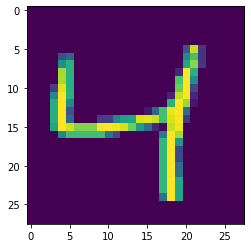

In [0]:
import matplotlib.pyplot as plt

imgplot = plt.imshow(train_dataset.data[2])

In [0]:
train_dataset.targets[2]

tensor(4)

In [0]:
train_dataset.data.max()

tensor(255, dtype=torch.uint8)

## Scale and prepare the dataset

In [0]:
X_train = train_dataset.data / 255.
y_train = train_dataset.targets
X_test = test_dataset.data / 255.
y_test = test_dataset.targets

In [0]:
X_train.max()

tensor(1.)

## Create the model
We're building a simple, dense neural network
The forward is how the network is traversed, the init defines the actual structure of the neural net.

In [0]:
class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [0]:
batch_size = 64
train_loader = DataLoader(TensorDataset(X_train,y_train), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test,y_test), batch_size=batch_size,shuffle=True)

In [0]:
model = DNN()

criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

## Training
We'll do 5 epochs, so all of the data will be seen 5 times.  We're going to iterate through the data loaders and train on 64 images at a time.

In [0]:
epochs = 5
print_every = 200
steps = 0
for e in range(epochs):
    running_loss = 0
    for step, (x,y) in enumerate(train_loader):
        # Flatten MNIST images into a 784 long vector
#        x.resize_(x.size()[0], 784)
        
        optimizer.zero_grad()
        
        # Forward and backward passes
        output = model.forward(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if step % print_every == 0:
            print("Epoch: {}/{}... ".format(e+1, epochs),
                  "Loss: {:.4f}".format(running_loss/print_every))
            
            running_loss = 0

Epoch: 1/5...  Loss: 0.0115
Epoch: 1/5...  Loss: 0.8589
Epoch: 1/5...  Loss: 0.3832
Epoch: 1/5...  Loss: 0.3236
Epoch: 1/5...  Loss: 0.2963
Epoch: 2/5...  Loss: 0.0012
Epoch: 2/5...  Loss: 0.2559
Epoch: 2/5...  Loss: 0.2327
Epoch: 2/5...  Loss: 0.2121
Epoch: 2/5...  Loss: 0.2070
Epoch: 3/5...  Loss: 0.0009
Epoch: 3/5...  Loss: 0.1809
Epoch: 3/5...  Loss: 0.1726
Epoch: 3/5...  Loss: 0.1719
Epoch: 3/5...  Loss: 0.1547
Epoch: 4/5...  Loss: 0.0006
Epoch: 4/5...  Loss: 0.1416
Epoch: 4/5...  Loss: 0.1473
Epoch: 4/5...  Loss: 0.1260
Epoch: 4/5...  Loss: 0.1308
Epoch: 5/5...  Loss: 0.0009
Epoch: 5/5...  Loss: 0.1230
Epoch: 5/5...  Loss: 0.1180
Epoch: 5/5...  Loss: 0.1107
Epoch: 5/5...  Loss: 0.1104


torch.nn defines nn.Module classes, torch nn.functional uses a functional (stateless) approach.
To dig a bit deeper: nn.Modules are defined as Python classes and have attributes, e.g. a nn.Conv2d module will have some internal attributes like self.weight. F.conv2d however just defines the operation and needs all arguments to be passed (including the weights and bias). Internally the modules will usually call their functional counterpart in the forward method somewhere.

In [0]:

test_loss = 0
correct = 0
with torch.no_grad():
    for data, target in test_loader:
        output = model(data)
        test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()

test_loss /= len(test_loader.dataset)

print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))


Test set: Average loss: 0.1156, Accuracy: 9662/10000 (97%)



## Accuracy metrics
Let's break down our accuracy function here into steps, because some of it probably is confusing.  

###First, let's make a prediction

We have to reshape the tensor to look like a batch.  The model was trained on data of batch_size x img_height x img_width; 64x28x28 data.  Now we're feeding it one sample that's 28x28, it's saying "I'm missing a dimension here", so we need to feed it a 'batch' of 1x28x28 to get a prediction.

Reshape of -1 says "make this as long or short as needed, based on the other dimensions", so here we're saying "reshape the matrix to 28x28 and as many batches as needed.

In [0]:
with torch.no_grad():
  print(model(X_test[0].reshape(-1,28,28)))

tensor([[-1.2341e+01, -1.6217e+01, -8.3700e+00, -5.9455e+00, -1.7039e+01,
         -1.1560e+01, -2.1767e+01, -2.8979e-03, -1.1646e+01, -1.0740e+01]])


In [0]:
with torch.no_grad():
  print(torch.max(model(X_test[10].reshape(-1,28,28)),1))

torch.return_types.max(
values=tensor([-0.0009]),
indices=tensor([0]))


In [0]:
#checks out
y_test[10]

tensor(0)

In [0]:
#now let's look at the loss function, this is getting the cumulative model error
F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss

6.4311699867248535

In [0]:
#this is the prediction, similar to what I did with torch.max
output.argmax(dim=1, keepdim=True)

tensor([[2],
        [4],
        [0],
        [7],
        [8],
        [4],
        [1],
        [9],
        [5],
        [1],
        [4],
        [1],
        [0],
        [6],
        [9],
        [3]])

In [0]:
#this is comparing the predictions to the actuals to get the accuracy score
pred.eq(target.view_as(pred)).sum().item()

14

# Fashion MNIST
A more challenging example, since a trivial neural net got 97% at MNIST.

In [0]:
trainset = datasets.FashionMNIST('F_MNIST_data/', download=True, train=True, transform=transforms.ToTensor())
trainset.data = trainset.data/255.
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('F_MNIST_data/', download=True, train=False, transform=transforms.ToTensor())
testset.data = testset.data/255.
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [0]:
trainset.data.max()

tensor(1.)

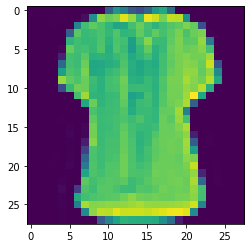

In [0]:
import matplotlib.pyplot as plt

imgplot = plt.imshow(trainset.data[55])

In [0]:
trainset.targets.max()

tensor(9)

In [0]:
class conv_net(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )

        conv_out_size = self._get_conv_out([1,28,28])
        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
            nn.LogSoftmax(dim=1)
        )

    def _get_conv_out(self, shape):
        o = self.conv(torch.zeros(1, *shape))
        return int(np.prod(o.size()))

    def forward(self, x):
        conv_out = self.conv(x).view(x.size()[0], -1)
        return self.fc(conv_out)

In [0]:
model = conv_net()
#model = DNN()
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)


In [0]:
epochs = 5
print_every = 200
for e in range(epochs):
    running_loss = 0
    for step, (x,y) in enumerate(trainloader):
        # Flatten MNIST images into a 784 long vector
#        x.resize_(x.size()[0], 784)
        
        optimizer.zero_grad()
        
        # Forward and backward passes
        output = model.forward(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if step > 1:
          if step % print_every == 0:
              print("Epoch: {}/{}... ".format(e+1, epochs),
                    "Loss: {:.4f}".format(running_loss/print_every))
              
              running_loss = 0

Epoch: 1/5...  Loss: 1.2823
Epoch: 1/5...  Loss: 0.9596
Epoch: 1/5...  Loss: 0.8923
Epoch: 1/5...  Loss: 0.8569
Epoch: 2/5...  Loss: 0.8237
Epoch: 2/5...  Loss: 0.7978
Epoch: 2/5...  Loss: 0.7979
Epoch: 2/5...  Loss: 0.7779
Epoch: 3/5...  Loss: 0.7561
Epoch: 3/5...  Loss: 0.7465
Epoch: 3/5...  Loss: 0.7443
Epoch: 3/5...  Loss: 0.7490
Epoch: 4/5...  Loss: 0.7130
Epoch: 4/5...  Loss: 0.7119
Epoch: 4/5...  Loss: 0.7061
Epoch: 4/5...  Loss: 0.7046
Epoch: 5/5...  Loss: 0.6775
Epoch: 5/5...  Loss: 0.6654
Epoch: 5/5...  Loss: 0.6744
Epoch: 5/5...  Loss: 0.6807


In [0]:
test_loss = 0
correct = 0
with torch.no_grad():
    for data, target in testloader:
        output = model(data)
        test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()

test_loss /= len(testloader.dataset)

print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(testloader.dataset),
    100. * correct / len(testloader.dataset)))


Test set: Average loss: 0.7860, Accuracy: 6955/10000 (70%)

